<a href="https://colab.research.google.com/github/drainlm/Facial-Recognition/blob/main/25_Percent_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers

from pyspark.sql import SparkSession

## Load the data 
40 subjects, each with 10 pictures

In [3]:
# Extract the zip file
with zipfile.ZipFile('/content/Faces.zip' , 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
# Set directory to access pictures
face_data = '/content/Faces' 

In [5]:
# Initialize lists to hold image data (flattened for Random Forest and Logistic Regression and original 2D for CNN) and its label
X_data = []
y_data = []
X_data_original = []

In [6]:
# Iterate through dataset directory
for dir_name in os.listdir(face_data):
    if os.path.isdir(os.path.join(face_data, dir_name)):
        label = dir_name
        for img_name in os.listdir(os.path.join(face_data, dir_name)):
            img_path = os.path.join(face_data, dir_name, img_name)
            img = Image.open(img_path).convert('L')  # convert to grayscale
            img_array = np.array(img)
            img_flattened = img_array.flatten() # flatten from 2D array to 1D array
            X_data.append(img_flattened)
            y_data.append(label)
            X_data_original.append(img_array) # keep original 2D array

## Exploratory Data Analysis

### Visualize entire dataset

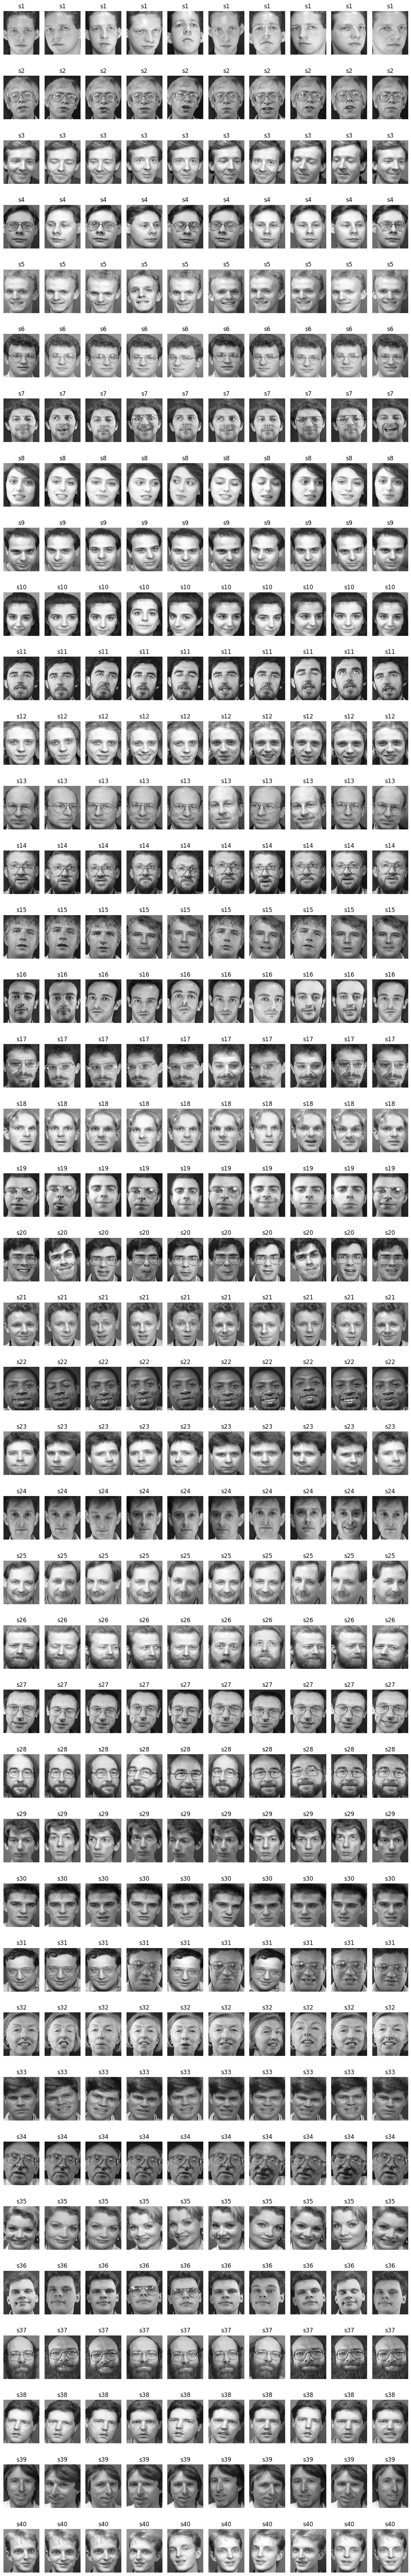

In [7]:
# View of all 400 images

# Organize the images by subject
subject_images = {}
for i in range(1, 41):
    subject = f's{i}'
    subject_images[subject] = [img for img, label in zip(X_data_original, y_data) if label == subject]

# Display all 10 images for each subject
rows = 40
cols = 10

fig, axes = plt.subplots(rows, cols, figsize=(12, 75))

for i, (subject, images) in enumerate(subject_images.items()):
    for j, img in enumerate(images):
        ax = axes[i, j]
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(subject)
        ax.axis('off')

plt.tight_layout()
plt.show()

### Check a specific subject's image set

In [8]:
# Accessing the data for a specific set of images
set_number = 's14' 
set_images = [img for img, label in zip(X_data, y_data) if label == set_number]

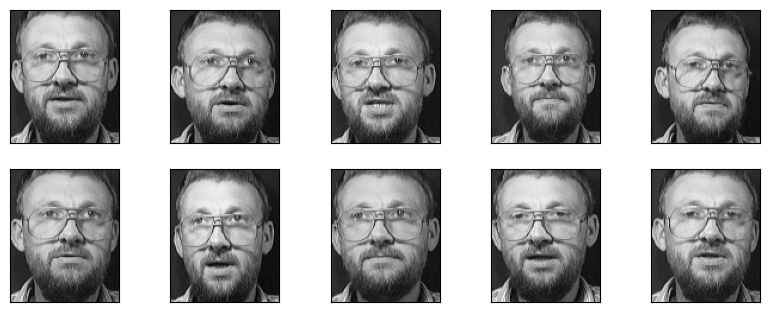

In [9]:
# Print the images from the specified set
plt.figure(figsize=(10, 10))
for i, img in enumerate(set_images):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
plt.show()

# Machine Learning Models

In [10]:
# Training and Testing Split (used for both Random Forest and Logistic Regression)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=1, stratify=y_data)

## Random Forest Classifier

Reference: https://notebook.community/mbeyeler/opencv-machine-learning/notebooks/10.03-Using-Random-Forests-for-Face-Recognition

In [11]:
# Assign Random Forest model 
RFmodel = RandomForestClassifier()

# Fit the Random Forest Classifier on the training data
RFmodel.fit(X_train, y_train)

RandomForestClassifier()

In [12]:
# Make predictions on the test set
RF_y_pred = RFmodel.predict(X_test)

In [13]:
# Generate a confusion matrix for Random Forest model
RFconfusion_matrix = confusion_matrix(y_test, RF_y_pred)
print(f"Random Forest Confusion Matrix:") 
print(RFconfusion_matrix)

Random Forest Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]


In [14]:
# Print the classification report for Random Forest model
RFclassification_report = classification_report(y_test, RF_y_pred)
print(f"Random Forest Classification Report:")
print(RFclassification_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

          s1       1.00      0.67      0.80         3
         s10       1.00      1.00      1.00         3
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       1.00      1.00      1.00         3
         s15       0.75      1.00      0.86         3
         s16       1.00      1.00      1.00         3
         s17       1.00      1.00      1.00         3
         s18       1.00      1.00      1.00         3
         s19       1.00      1.00      1.00         2
          s2       0.75      1.00      0.86         3
         s20       1.00      1.00      1.00         3
         s21       0.60      1.00      0.75         3
         s22       1.00      1.00      1.00         2
         s23       1.00      1.00      1.00         3
         s24       1.00      1.00      1.00 

In [15]:
# Print the balanced_accuracy score of Random Forest model
RF_balanced_accuracy_score = balanced_accuracy_score(y_test, RF_y_pred)
print(f"Random Forest Balanced Accuracy Score : {RF_balanced_accuracy_score * 100:.2f}%")

Random Forest Balanced Accuracy Score : 93.33%


In [16]:
# Finding Misclassified images in Random Forest
# Convert y_test and RF_y_pred to numpy arrays
y_test_array = np.array(y_test)
RF_y_pred_array = np.array(RF_y_pred)

# Find indices of misclassified examples
RFmisclassified = np.where(y_test_array != RF_y_pred_array)[0]

# Print the number of misclassified examples
print("Number of misclassified examples:", len(RFmisclassified))

# Create dataframe of misclassified examples
RFmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[RFmisclassified],
    'Predicted Label': RF_y_pred_array[RFmisclassified]
})
RFmisclassified_df

Number of misclassified examples: 7


True Label Predicted Label
0        s28             s37
1         s1             s31
2        s33             s21
3        s35             s15
4        s40              s5
5        s31             s21
6        s32              s2

##Logistic Regression

In [17]:
# Scale the data for Logistic Regression
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Assign Logistic Regression model
LRmodel = LogisticRegression(max_iter=2500)

# Fit Logistic Regression model using training data
LRmodel.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2500)

In [19]:
# Make a prediction using the testing data
LR_y_pred = LRmodel.predict(X_test_scaled)

In [20]:
# Generate a confusion matrix for Logistic Regression model
LRconfusion_matrix = confusion_matrix(y_test, LR_y_pred)
print(f"Logistic Regression Confusion Matrix:") 
print(LRconfusion_matrix)

Logistic Regression Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 1 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]


In [21]:
# Print the classification report for Logistic Regression model
LRclassification_report = classification_report(y_test, LR_y_pred)
print(f"Logistic Regression Classification Report:")
print(LRclassification_report)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         3
         s10       1.00      0.67      0.80         3
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         2
         s13       1.00      1.00      1.00         2
         s14       1.00      1.00      1.00         3
         s15       1.00      1.00      1.00         3
         s16       1.00      1.00      1.00         3
         s17       1.00      1.00      1.00         3
         s18       1.00      1.00      1.00         3
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         3
         s20       1.00      1.00      1.00         3
         s21       1.00      1.00      1.00         3
         s22       1.00      1.00      1.00         2
         s23       1.00      1.00      1.00         3
         s24       1.00      1.00     

In [22]:
# Print the balanced_accuracy score of Logistic Regression model
LR_balanced_accuracy_score = balanced_accuracy_score(y_test, LR_y_pred)
print(f"Logistic Regression Balanced Accuracy Score : {LR_balanced_accuracy_score * 100:.2f}%")

Logistic Regression Balanced Accuracy Score : 97.50%


In [69]:
# Finding Misclassified and Correctly Classified images in Logistic Regression
# Convert y_test and LR_y_pred to numpy arrays
y_test_array = np.array(y_test)
LR_y_pred_array = np.array(LR_y_pred)

# Find indices of misclassified examples
LRmisclassified = np.where(y_test_array != LR_y_pred_array)[0]

# Create dataframe of misclassified examples
LRmisclassified_df = pd.DataFrame({
    'True Label': y_test_array[LRmisclassified],
    'Predicted Label': LR_y_pred_array[LRmisclassified]
})
LRmisclassified_df

True Label Predicted Label
0        s28             s37
1        s40              s5
2        s10              s8

# Convolutional Neural Network (CNN) 
Reference: https://selectstar-ai.medium.com/what-is-mnist-and-why-is-it-important-e9a269edbad5

In [24]:
# Create numpy array
X_data_original = np.array(X_data_original)
y_data = np.array(y_data)

# Split the original image data into training and testing sets, use random_state 1
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_data_original, y_data, test_size=0.25, random_state=1, stratify=y_data)

print('Original Images:')
print('X_train_original = %s, y_train_original = %s' % (X_train_original.shape, y_train_original.shape))
print('X_test_original = %s, y_test_original = %s' % (X_test_original.shape, y_test_original.shape))

Original Images:
X_train_original = (300, 112, 92), y_train_original = (300,)
X_test_original = (100, 112, 92), y_test_original = (100,)


In [25]:
# Reshaping the array to become 4-dimensional
X_train_original  = X_train_original.reshape(X_train_original.shape[0], 112, 92, 1)
X_test_original = X_test_original.reshape(X_test_original.shape[0], 112, 92, 1)

print('After reshaping, X_train_original is :', X_train_original.shape)
print('X_train_original contains', X_train_original.shape[0], "images")
print('X_test_original contains', X_test_original.shape[0], "images")

After reshaping, X_train_original is : (300, 112, 92, 1)
X_train_original contains 300 images
X_test_original contains 100 images


In [26]:
# To ensure decimal points after division
X_train_original = X_train_original.astype('float32')
X_test_original = X_test_original.astype('float32')

# Normalizing the RGB codes by dividing it by the max RGB value
X_train_original /= 255
X_test_original /= 255

In [27]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_original)
y_test_encoded = label_encoder.transform(y_test_original)

In [28]:
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

In [29]:
# Create a dataframe to store the results for model optimization
results = pd.DataFrame(columns=["Model_Version", "Test_Loss", "Test_Accuracy"])

### CNN Model Version 1 - original codeblock from referenced link

In [30]:
# Creating a sequential model named 
CNN_v1 = models.Sequential()

# Adding convolutional layer
CNN_v1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v1.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v1.add(layers.Flatten())

# Full connection
CNN_v1.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v1.add(layers.Dense(40, activation='softmax'))

In [31]:
# Compile the model
CNN_v1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Fit the model
history = CNN_v1.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v1.evaluate(X_test_original, y_test_encoded)
y_pred_v1 = CNN_v1.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v1
classification_report_v1 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v1, axis=1), zero_division=0)
print("CNN_v1 Classification Report:")
print(classification_report_v1)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v1
test_loss, test_accuracy = CNN_v1.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v1", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v1 model
CNN_v1.save("CNN_v1.h5")

Epoch 1/10
8/8 [==============================] - 6s 563ms/step - loss: 21.6723 - accuracy: 0.0292 - val_loss: 10.9439 - val_accuracy: 0.0000e+00
Epoch 2/10
8/8 [==============================] - 4s 569ms/step - loss: 5.5154 - accuracy: 0.0167 - val_loss: 3.6891 - val_accuracy: 0.0167
Epoch 3/10
8/8 [==============================] - 5s 669ms/step - loss: 3.6890 - accuracy: 0.0292 - val_loss: 3.6897 - val_accuracy: 0.0167
Epoch 4/10
8/8 [==============================] - 8s 898ms/step - loss: 3.6888 - accuracy: 0.0292 - val_loss: 3.6904 - val_accuracy: 0.0167
Epoch 5/10
8/8 [==============================] - 3s 353ms/step - loss: 3.6886 - accuracy: 0.0250 - val_loss: 3.6911 - val_accuracy: 0.0000e+00
Epoch 6/10
8/8 [==============================] - 3s 356ms/step - loss: 3.6884 - accuracy: 0.0333 - val_loss: 3.6917 - val_accuracy: 0.0000e+00
Epoch 7/10
8/8 [==============================] - 3s 368ms/step - loss: 3.6883 - accuracy: 0.0292 - val_loss: 3.6926 - val_accuracy: 0.0000e+00
Ep

<ipython-input-32-5e4559fa928d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v1", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 2 - added a convolutional layer

In [33]:
# Creating a sequential model named 
CNN_v2 = models.Sequential()

# First convolutional layer
CNN_v2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v2.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v2.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v2.add(layers.Flatten())

# Full connection
CNN_v2.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v2.add(layers.Dense(40, activation='softmax'))

In [34]:
# Compile the model
CNN_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Fit the model
history = CNN_v2.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v2.evaluate(X_test_original, y_test_encoded)
y_pred_v2 = CNN_v2.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v2
classification_report_v2 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v2, axis=1))
print("CNN_v2 Classification Report:")
print(classification_report_v2)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v2
test_loss, test_accuracy = CNN_v2.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v2", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v2 model
CNN_v2.save("CNN_v2.h5")

Epoch 1/10
8/8 [==============================] - 6s 680ms/step - loss: 4.9418 - accuracy: 0.0292 - val_loss: 3.7139 - val_accuracy: 0.0333
Epoch 2/10
8/8 [==============================] - 3s 426ms/step - loss: 3.6521 - accuracy: 0.0375 - val_loss: 3.6210 - val_accuracy: 0.0333
Epoch 3/10
8/8 [==============================] - 3s 416ms/step - loss: 3.5312 - accuracy: 0.0750 - val_loss: 3.5176 - val_accuracy: 0.0667
Epoch 4/10
8/8 [==============================] - 3s 405ms/step - loss: 3.3152 - accuracy: 0.1042 - val_loss: 3.3411 - val_accuracy: 0.1667
Epoch 5/10
8/8 [==============================] - 5s 592ms/step - loss: 2.9835 - accuracy: 0.3250 - val_loss: 3.1911 - val_accuracy: 0.1500
Epoch 6/10
8/8 [==============================] - 3s 415ms/step - loss: 2.5474 - accuracy: 0.3833 - val_loss: 2.8826 - val_accuracy: 0.2500
Epoch 7/10
8/8 [==============================] - 3s 401ms/step - loss: 2.0185 - accuracy: 0.4833 - val_loss: 2.4327 - val_accuracy: 0.3833
Epoch 8/10
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 70ms/step - loss: 1.2115 - accuracy: 0.6900


<ipython-input-35-ace8be32a4ee>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v2", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 3 - doubled epochs from 10 to 20

In [36]:
# Creating a sequential model named 
CNN_v3 = models.Sequential()

# First convolutional layer
CNN_v3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v3.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v3.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v3.add(layers.Flatten())

# Full connection
CNN_v3.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v3.add(layers.Dense(40, activation='softmax'))

In [37]:
# Compile the model
CNN_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Fit the model
history = CNN_v3.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v3.evaluate(X_test_original, y_test_encoded)
y_pred_v3 = CNN_v3.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v3
classification_report_v3 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v3, axis=1))
print("CNN_v3 Classification Report:")
print(classification_report_v3)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v3
test_loss, test_accuracy = CNN_v3.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v3", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v3 model
CNN_v3.save("CNN_v3.h5")

Epoch 1/20
8/8 [==============================] - 7s 657ms/step - loss: 7.2179 - accuracy: 0.0125 - val_loss: 3.6829 - val_accuracy: 0.0500
Epoch 2/20
8/8 [==============================] - 3s 419ms/step - loss: 3.7163 - accuracy: 0.0208 - val_loss: 3.7247 - val_accuracy: 0.0500
Epoch 3/20
8/8 [==============================] - 3s 415ms/step - loss: 3.6592 - accuracy: 0.0250 - val_loss: 3.6522 - val_accuracy: 0.0500
Epoch 4/20
8/8 [==============================] - 3s 421ms/step - loss: 3.6137 - accuracy: 0.0458 - val_loss: 3.6312 - val_accuracy: 0.0333
Epoch 5/20
8/8 [==============================] - 5s 610ms/step - loss: 3.5446 - accuracy: 0.0708 - val_loss: 3.5720 - val_accuracy: 0.0667
Epoch 6/20
8/8 [==============================] - 3s 418ms/step - loss: 3.4317 - accuracy: 0.0917 - val_loss: 3.5582 - val_accuracy: 0.0333
Epoch 7/20
8/8 [==============================] - 3s 400ms/step - loss: 3.2950 - accuracy: 0.1458 - val_loss: 3.5224 - val_accuracy: 0.0500
Epoch 8/20
8/8 [====

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 77ms/step - loss: 1.1200 - accuracy: 0.6900


<ipython-input-38-8e8af20091f0>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v3", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 4 - added a third convolutional layer

In [39]:
# Creating a sequential model named 
CNN_v4 = models.Sequential()

# First convolutional layer
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v4.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v4.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v4.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v4.add(layers.Flatten())

# Full connection
CNN_v4.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v4.add(layers.Dense(40, activation='softmax'))

In [40]:
# Compile the model
CNN_v4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
# Fit the model
history = CNN_v4.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v4.evaluate(X_test_original, y_test_encoded)
y_pred_v4 = CNN_v4.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v4
classification_report_v4 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v4, axis=1))
print("CNN_v4 Classification Report:")
print(classification_report_v4)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v4
test_loss, test_accuracy = CNN_v4.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v4", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v4 model
CNN_v4.save("CNN_v4.h5")

Epoch 1/20
8/8 [==============================] - 5s 474ms/step - loss: 3.7665 - accuracy: 0.0125 - val_loss: 3.7174 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 4s 524ms/step - loss: 3.6427 - accuracy: 0.0750 - val_loss: 3.6353 - val_accuracy: 0.1167
Epoch 3/20
8/8 [==============================] - 4s 484ms/step - loss: 3.4965 - accuracy: 0.1833 - val_loss: 3.5060 - val_accuracy: 0.2333
Epoch 4/20
8/8 [==============================] - 4s 444ms/step - loss: 3.1841 - accuracy: 0.2375 - val_loss: 3.2621 - val_accuracy: 0.2333
Epoch 5/20
8/8 [==============================] - 3s 412ms/step - loss: 2.7031 - accuracy: 0.4583 - val_loss: 2.6342 - val_accuracy: 0.3500
Epoch 6/20
8/8 [==============================] - 5s 685ms/step - loss: 1.8928 - accuracy: 0.6125 - val_loss: 1.9700 - val_accuracy: 0.3667
Epoch 7/20
8/8 [==============================] - 3s 430ms/step - loss: 1.1855 - accuracy: 0.7583 - val_loss: 1.3618 - val_accuracy: 0.6667
Epoch 8/20
8/8 [

<ipython-input-41-901e7df101ad>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v4", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 5 - doubled the filters in layer 2, tripled in layer 3

In [42]:
# Creating a sequential model named 
CNN_v5 = models.Sequential()

# First convolutional layer
CNN_v5.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v5.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v5.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v5.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v5.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v5.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v5.add(layers.Flatten())

# Full connection
CNN_v5.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v5.add(layers.Dense(40, activation='softmax'))

In [43]:
# Compile the model
CNN_v5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Fit the model
history = CNN_v5.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v5.evaluate(X_test_original, y_test_encoded)
y_pred_v5 = CNN_v5.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v5
classification_report_v5 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v5, axis=1))
print("CNN_v5 Classification Report:")
print(classification_report_v5)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v5
test_loss, test_accuracy = CNN_v5.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v5", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v5 model
CNN_v5.save("CNN_v5.h5")

Epoch 1/20
8/8 [==============================] - 7s 745ms/step - loss: 4.3288 - accuracy: 0.0250 - val_loss: 3.6992 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 6s 660ms/step - loss: 3.6896 - accuracy: 0.0333 - val_loss: 3.6981 - val_accuracy: 0.0333
Epoch 3/20
8/8 [==============================] - 5s 637ms/step - loss: 3.6566 - accuracy: 0.0417 - val_loss: 3.6397 - val_accuracy: 0.0667
Epoch 4/20
8/8 [==============================] - 7s 864ms/step - loss: 3.5406 - accuracy: 0.1000 - val_loss: 3.5366 - val_accuracy: 0.1667
Epoch 5/20
8/8 [==============================] - 5s 662ms/step - loss: 3.2776 - accuracy: 0.2625 - val_loss: 3.2404 - val_accuracy: 0.2333
Epoch 6/20
8/8 [==============================] - 7s 927ms/step - loss: 2.7421 - accuracy: 0.3500 - val_loss: 2.8194 - val_accuracy: 0.3167
Epoch 7/20
8/8 [==============================] - 7s 786ms/step - loss: 1.9802 - accuracy: 0.5708 - val_loss: 2.2222 - val_accuracy: 0.4000
Epoch 8/20
8/8 [

<ipython-input-44-c62640e60169>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v5", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 6 - Early Stopping and increased epochs from 20 to 50

In [45]:
from keras.callbacks import EarlyStopping

# Creating a sequential model named 
CNN_v6 = models.Sequential()

# First convolutional layer
CNN_v6.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v6.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v6.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v6.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v6.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v6.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v6.add(layers.Flatten())

# Full connection
CNN_v6.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v6.add(layers.Dense(40, activation='softmax'))

In [46]:
# Compiling the model
CNN_v6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Setting early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Fitting the model to the training data
history = CNN_v6.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=50, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v6.evaluate(X_test_original, y_test_encoded)
y_pred_v6 = CNN_v6.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v6
classification_report_v6 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v6, axis=1))
print("CNN_v6 Classification Report:")
print(classification_report_v6)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v6
test_loss, test_accuracy = CNN_v6.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v6", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v6 model
CNN_v6.save("CNN_v6.h5")

Epoch 1/50
8/8 [==============================] - 8s 748ms/step - loss: 4.0843 - accuracy: 0.0042 - val_loss: 3.6904 - val_accuracy: 0.0333
Epoch 2/50
8/8 [==============================] - 6s 776ms/step - loss: 3.6973 - accuracy: 0.0583 - val_loss: 3.6589 - val_accuracy: 0.0333
Epoch 3/50
8/8 [==============================] - 6s 684ms/step - loss: 3.5866 - accuracy: 0.1208 - val_loss: 3.5531 - val_accuracy: 0.0333
Epoch 4/50
8/8 [==============================] - 5s 643ms/step - loss: 3.3686 - accuracy: 0.1292 - val_loss: 3.4523 - val_accuracy: 0.1333
Epoch 5/50
8/8 [==============================] - 7s 938ms/step - loss: 2.9654 - accuracy: 0.2542 - val_loss: 3.0717 - val_accuracy: 0.1333
Epoch 6/50
8/8 [==============================] - 5s 660ms/step - loss: 2.3590 - accuracy: 0.4042 - val_loss: 2.6304 - val_accuracy: 0.1833
Epoch 7/50
8/8 [==============================] - 7s 941ms/step - loss: 1.6900 - accuracy: 0.5708 - val_loss: 2.1275 - val_accuracy: 0.4333
Epoch 8/50
8/8 [====

<ipython-input-47-ba38e4042556>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v6", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


### CNN Model Version 7 - Added 3rd Dense Layer

In [48]:
# Creating a sequential model named 
CNN_v7 = models.Sequential()

# First convolutional layer
CNN_v7.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v7.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v7.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v7.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v7.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v7.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v7.add(layers.Flatten())

# Full connection
CNN_v7.add(layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNN_v7.add(layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))  # Third dense layer
CNN_v7.add(layers.Dense(40, activation='softmax'))

In [49]:
# Compile the model
CNN_v7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# Fit the model
history = CNN_v7.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v7.evaluate(X_test_original, y_test_encoded)
y_pred_v7 = CNN_v7.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v7
classification_report_v7 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v7, axis=1))
print("CNN_v7 Classification Report:")
print(classification_report_v7)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v7
test_loss, test_accuracy = CNN_v7.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v7", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v7 model
CNN_v7.save("CNN_v7.h5")

Epoch 1/20
8/8 [==============================] - 7s 733ms/step - loss: 4.1262 - accuracy: 0.0375 - val_loss: 3.7185 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 7s 877ms/step - loss: 3.6632 - accuracy: 0.0667 - val_loss: 3.6752 - val_accuracy: 0.0000e+00
Epoch 3/20
8/8 [==============================] - 7s 926ms/step - loss: 3.6135 - accuracy: 0.0792 - val_loss: 3.6050 - val_accuracy: 0.1167
Epoch 4/20
8/8 [==============================] - 11s 1s/step - loss: 3.4761 - accuracy: 0.1375 - val_loss: 3.4670 - val_accuracy: 0.0500
Epoch 5/20
8/8 [==============================] - 6s 694ms/step - loss: 3.1873 - accuracy: 0.1500 - val_loss: 3.2045 - val_accuracy: 0.0833
Epoch 6/20
8/8 [==============================] - 7s 938ms/step - loss: 2.6434 - accuracy: 0.3000 - val_loss: 3.1917 - val_accuracy: 0.1167
Epoch 7/20
8/8 [==============================] - 5s 654ms/step - loss: 2.0572 - accuracy: 0.4750 - val_loss: 2.4055 - val_accuracy: 0.2833
Epoch 8/20
8/8

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 1s 128ms/step - loss: 0.5404 - accuracy: 0.8600


<ipython-input-50-1b537338738d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v7", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


##CNN Model Version 8 - Added a Dropout Layer, increased dense layer neurons 100 to 256 and 50 128

In [51]:
# Creating a sequential model named
CNN_v8 = models.Sequential()

# First convolutional layer
CNN_v8.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v8.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v8.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v8.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v8.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v8.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v8.add(layers.Flatten())

# Dropout regularization
CNN_v8.add(layers.Dropout(0.5))  

# Full connection
CNN_v8.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
CNN_v8.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
CNN_v8.add(layers.Dense(40, activation='softmax'))

In [52]:
# Compile the model
CNN_v8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
# Fit the model
history = CNN_v8.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v8.evaluate(X_test_original, y_test_encoded)
y_pred_v8 = CNN_v8.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v8
classification_report_v8 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v8, axis=1))
print("CNN_v8 Classification Report:")
print(classification_report_v8)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v8
test_loss, test_accuracy = CNN_v8.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v8", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v8 model
CNN_v8.save("CNN_v8.h5")

Epoch 1/20
8/8 [==============================] - 9s 1s/step - loss: 4.5608 - accuracy: 0.0042 - val_loss: 3.6729 - val_accuracy: 0.0333
Epoch 2/20
8/8 [==============================] - 6s 719ms/step - loss: 3.6994 - accuracy: 0.0333 - val_loss: 3.6640 - val_accuracy: 0.0667
Epoch 3/20
8/8 [==============================] - 7s 922ms/step - loss: 3.6116 - accuracy: 0.0625 - val_loss: 3.5498 - val_accuracy: 0.1333
Epoch 4/20
8/8 [==============================] - 6s 717ms/step - loss: 3.4315 - accuracy: 0.1458 - val_loss: 3.2959 - val_accuracy: 0.1167
Epoch 5/20
8/8 [==============================] - 7s 917ms/step - loss: 2.9547 - accuracy: 0.2958 - val_loss: 2.6807 - val_accuracy: 0.3667
Epoch 6/20
8/8 [==============================] - 7s 966ms/step - loss: 2.0267 - accuracy: 0.5042 - val_loss: 1.9003 - val_accuracy: 0.4833
Epoch 7/20
8/8 [==============================] - 7s 971ms/step - loss: 1.1208 - accuracy: 0.7125 - val_loss: 1.4637 - val_accuracy: 0.5667
Epoch 8/20
8/8 [=======

<ipython-input-53-b5748d842a34>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v8", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


## CNN Model Version 9 - building from version 4, adding 2nd dense layer with increased neurons 

In [54]:
# Creating a sequential model named 
CNN_v9 = models.Sequential()

# First convolutional layer
CNN_v9.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(112, 92, 1)))
CNN_v9.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
CNN_v9.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v9.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
CNN_v9.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_v9.add(layers.MaxPooling2D((2, 2)))

# Flattening
CNN_v9.add(layers.Flatten())

# Full connection
CNN_v9.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
CNN_v9.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
CNN_v9.add(layers.Dense(40, activation='softmax'))

In [55]:
# Compile the model
CNN_v9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
# Fit the model
history = CNN_v9.fit(x=X_train_original, y=y_train_encoded, validation_split=0.2, epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = CNN_v9.evaluate(X_test_original, y_test_encoded)
y_pred_v9 = CNN_v9.predict(X_test_original)

# Calculate precision, recall, and F1-score for CNN_v9
classification_report_v9 = classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_v9, axis=1))
print("CNN_v9 Classification Report:")
print(classification_report_v9)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate and save the results of CNN_v9
test_loss, test_accuracy = CNN_v9.evaluate(X_test_original, y_test_encoded)
results = results.append({"Model_Version": "CNN_v9", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)

# Save the CNN_v9 model
CNN_v9.save("CNN_v9.h5")

Epoch 1/20
8/8 [==============================] - 6s 562ms/step - loss: 3.9592 - accuracy: 0.0167 - val_loss: 3.7283 - val_accuracy: 0.0000e+00
Epoch 2/20
8/8 [==============================] - 5s 554ms/step - loss: 3.6682 - accuracy: 0.0583 - val_loss: 3.6726 - val_accuracy: 0.0667
Epoch 3/20
8/8 [==============================] - 4s 454ms/step - loss: 3.5954 - accuracy: 0.1083 - val_loss: 3.6037 - val_accuracy: 0.0500
Epoch 4/20
8/8 [==============================] - 4s 461ms/step - loss: 3.4012 - accuracy: 0.2125 - val_loss: 3.5237 - val_accuracy: 0.0500
Epoch 5/20
8/8 [==============================] - 5s 704ms/step - loss: 3.0502 - accuracy: 0.3042 - val_loss: 3.1240 - val_accuracy: 0.2000
Epoch 6/20
8/8 [==============================] - 4s 438ms/step - loss: 2.5409 - accuracy: 0.3333 - val_loss: 2.6951 - val_accuracy: 0.2333
Epoch 7/20
8/8 [==============================] - 4s 444ms/step - loss: 1.7247 - accuracy: 0.6042 - val_loss: 1.9929 - val_accuracy: 0.2667
Epoch 8/20
8/8 [

<ipython-input-56-cc20724cc293>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model_Version": "CNN_v9", "Test_Loss": test_loss, "Test_Accuracy": test_accuracy}, ignore_index=True)


In [57]:
print(results)

  Model_Version  Test_Loss  Test_Accuracy
0        CNN_v1   3.688928           0.02
1        CNN_v2   1.211469           0.69
2        CNN_v3   1.119976           0.69
3        CNN_v4   0.386237           0.88
4        CNN_v5   0.296974           0.90
5        CNN_v6   0.401601           0.90
6        CNN_v7   0.540400           0.86
7        CNN_v8   0.514514           0.89
8        CNN_v9   0.382574           0.92


In [58]:
# Get the predicted labels for the test set from the best performing CNN model
y_pred_cnn_v9 = np.argmax(y_pred_v9, axis=1)

# Calculate the balanced accuracy score for CNN Version 9
balanced_acc_best = balanced_accuracy_score(np.argmax(y_test_encoded, axis=1), y_pred_cnn_v9)

# Print the balanced accuracy score for CNN Version 9
print(f"CNN Version 9 Balanced Accuracy: {balanced_acc_best * 100:.2f}%")

CNN Version 9 Balanced Accuracy: 92.50%


### Visualizations for CNN Model Versions

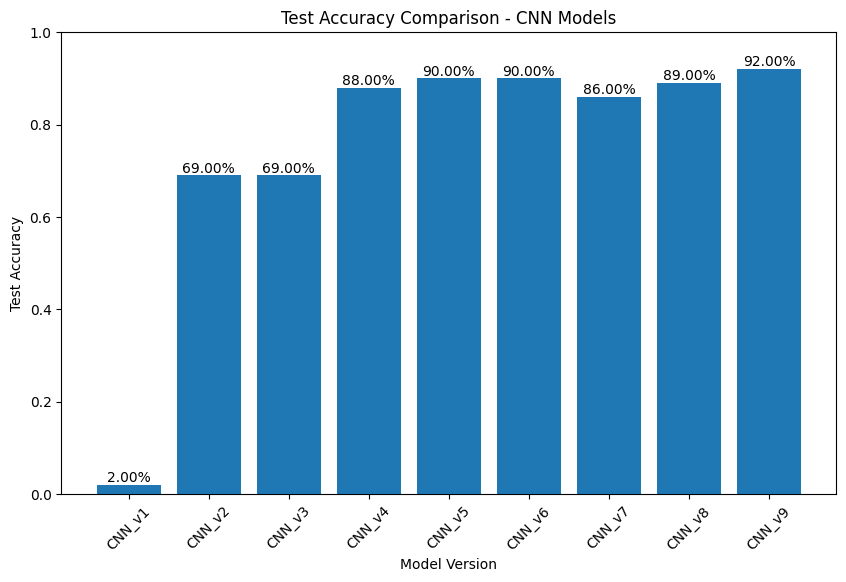

In [59]:
plt.figure(figsize=(10, 6))
bars = plt.bar(results["Model_Version"], results["Test_Accuracy"])
plt.xlabel("Model Version")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison - CNN Models")
plt.ylim([0, 1])
plt.xticks(rotation=45)

# Add the test accuracy values on top of each bar
for i, rect in enumerate(bars):
    height = rect.get_height()
    test_accuracy = results["Test_Accuracy"][i]
    plt.text(rect.get_x() + rect.get_width() / 2, height, f"{test_accuracy:.2%}", ha="center", va="bottom")

plt.show()

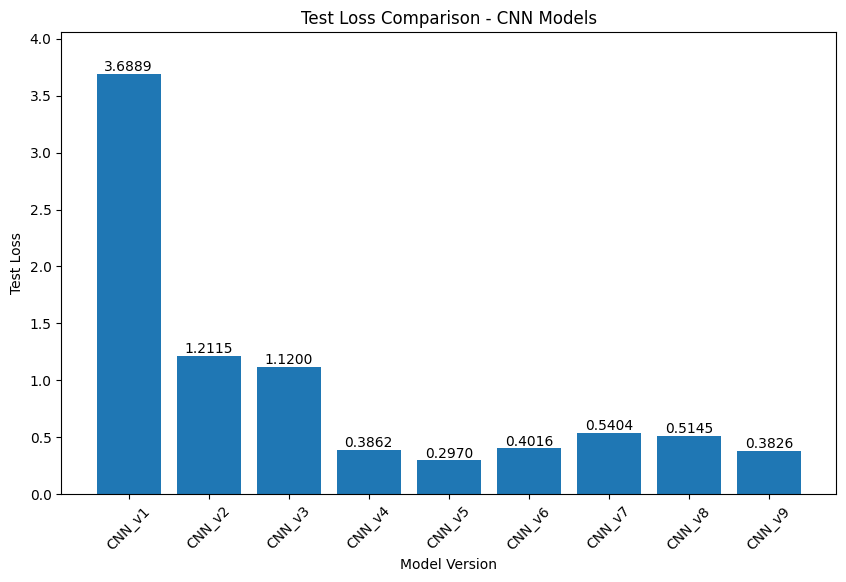

In [60]:
plt.figure(figsize=(10, 6))
bars = plt.bar(results["Model_Version"], results["Test_Loss"])
plt.xlabel("Model Version")
plt.ylabel("Test Loss")
plt.title("Test Loss Comparison - CNN Models")
plt.ylim([0, max(results["Test_Loss"]) * 1.1])
plt.xticks(rotation=45)

# Add the test loss values on top of each bar
for i, rect in enumerate(bars):
    height = rect.get_height()
    test_loss = results["Test_Loss"][i]
    plt.text(rect.get_x() + rect.get_width() / 2, height, f"{test_loss:.4f}", ha="center", va="bottom")

plt.show()

# Comparative Visualizations Across Random Forest, Logistic Regression, and CNN

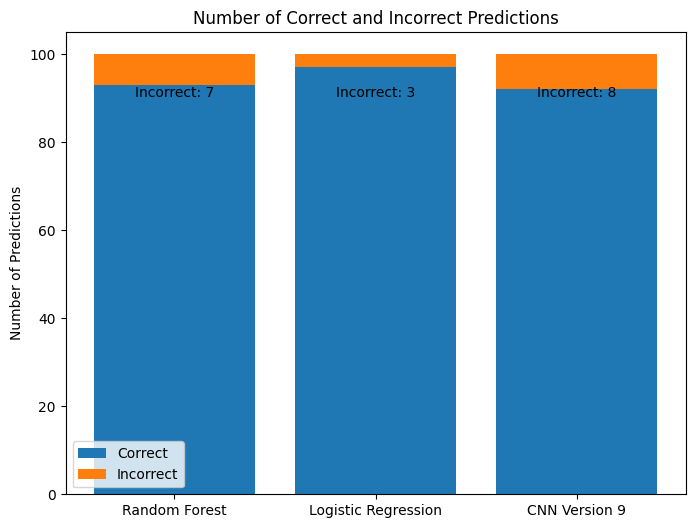

In [61]:
# Calculate number of correct and incorrect predictions for each model
correct_predictions_rf = sum(y_test_array == RF_y_pred_array)
incorrect_predictions_rf = sum(y_test_array != RF_y_pred_array)

correct_predictions_lr = sum(y_test_array == LR_y_pred_array)
incorrect_predictions_lr = sum(y_test_array != LR_y_pred_array)

correct_predictions_cnn_v9 = np.sum(np.argmax(y_test_encoded, axis=1) == np.argmax(y_pred_v9, axis=1))
incorrect_predictions_cnn_v9 = np.sum(np.argmax(y_test_encoded, axis=1) != np.argmax(y_pred_v9, axis=1))

# Create stacked bar chart
labels = ["Random Forest", "Logistic Regression", "CNN Version 9"]
correct_predictions = [correct_predictions_rf, correct_predictions_lr, correct_predictions_cnn_v9]
incorrect_predictions = [incorrect_predictions_rf, incorrect_predictions_lr, incorrect_predictions_cnn_v9]

plt.figure(figsize=(8, 6))
plt.bar(labels, correct_predictions, label="Correct")
plt.bar(labels, incorrect_predictions, bottom=correct_predictions, label="Incorrect")
plt.ylabel("Number of Predictions")
plt.title("Number of Correct and Incorrect Predictions")
plt.legend(loc='lower left')

# Print the number of incorrect predictions on each bar, slightly below the top of the graph
for i in range(len(labels)):
    plt.text(labels[i], correct_predictions[i] + incorrect_predictions[i] + -0.1 * max(correct_predictions), f"Incorrect: {incorrect_predictions[i]}", ha='center')

plt.show()

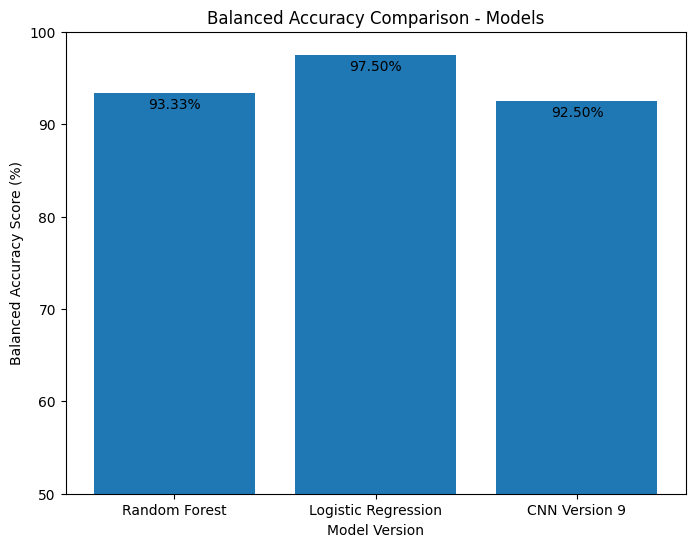

In [62]:
# Define the model versions and their corresponding balanced accuracy scores
model_versions = ['Random Forest', 'Logistic Regression', 'CNN Version 9']
balanced_accuracy_scores = [RF_balanced_accuracy_score, LR_balanced_accuracy_score, balanced_acc_best]

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(model_versions, [score*100 for score in balanced_accuracy_scores])  # Convert scores to percentage
plt.ylim([50, 100])  # Set the y-axis limits to [50, 100]
plt.xlabel('Model Version')
plt.ylabel('Balanced Accuracy Score (%)')
plt.title('Balanced Accuracy Comparison - Models')

# Add the balanced accuracy scores as text (percentage) on top of each bar
for bar, score in zip(bars, balanced_accuracy_scores):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() - 2  # Adjust the vertical position of the text
    plt.text(x, y, f'{score*100:.2f}%', ha='center', va='bottom')

plt.show()

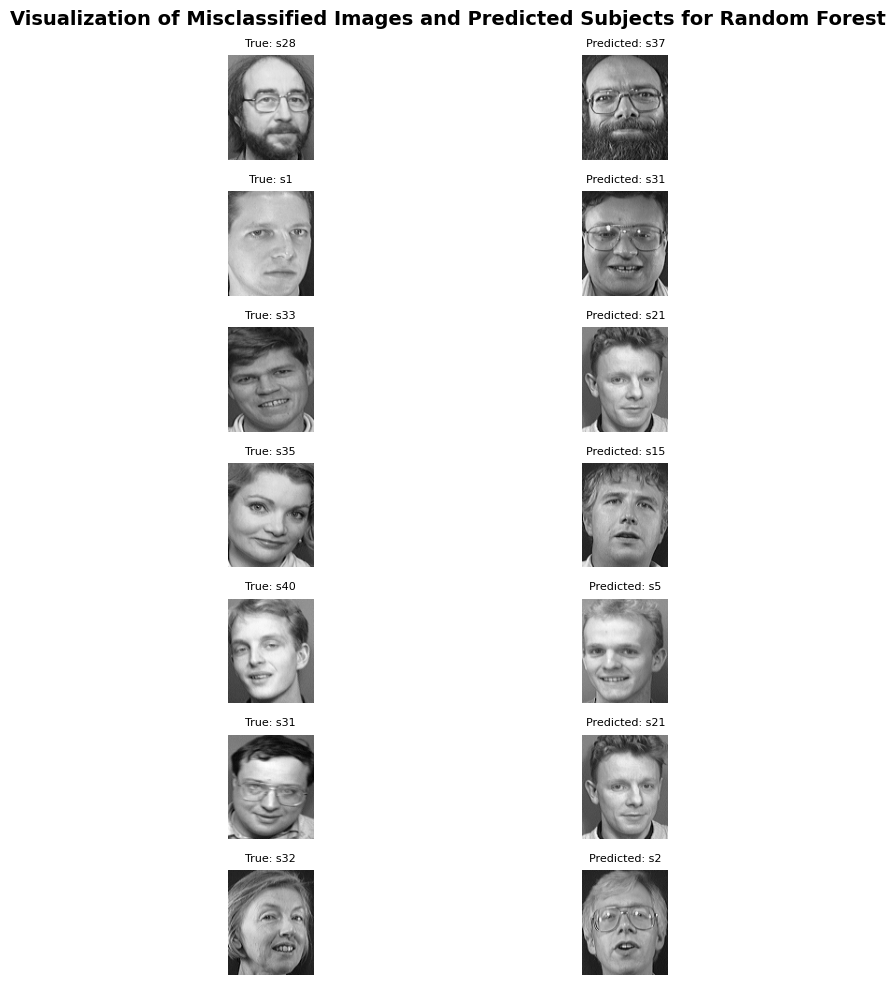

In [63]:
# Set the number of rows and columns for the subplots
rows = len(RFmisclassified)
cols = 2

# Check if rows is 0
if rows == 0:
    print("No misclassified images for Random Forest.")
else:
    # Adjust the number of columns if there are not enough columns to accommodate the plots
    if cols < 2:
        cols = 2

    # Create the subplot grid
    if rows == 1:
        fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
        axes = np.expand_dims(axes, axis=0)  # Convert axes to a 2-dimensional array
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    # Iterate through misclassified images and display the corresponding images
    for i, index in enumerate(RFmisclassified):
        img = X_test[index]
        true_label = y_test_array[index]
        pred_label = RF_y_pred_array[index]

        # Find the index of the first image for the predicted subject
        predicted_subject_index = np.where(y_test_array == pred_label)[0][0]
        predicted_subject_image = X_test[predicted_subject_index]

        # Calculate the row and column index for the subplot axes
        row = i
        col = 0

        # Plot the true subject image
        axes[row, col].imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
        axes[row, col].set_title(f"True: {true_label}", fontsize=8)
        axes[row, col].axis('off')

        # Plot the predicted subject image
        axes[row, col + 1].imshow(predicted_subject_image.reshape((112, 92)), cmap=plt.cm.gray)
        axes[row, col + 1].set_title(f"Predicted: {pred_label}", fontsize=8)
        axes[row, col + 1].axis('off')

    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Random Forest", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

IndexError: ignored

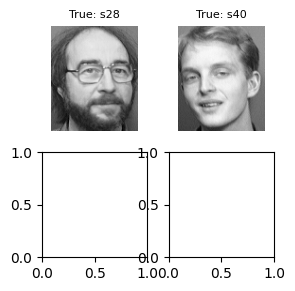

In [64]:
# Set the number of columns for the subplots
cols = 2

# Calculate the number of rows required based on the number of misclassified images
rows = (len(LRmisclassified) + 1) // cols

# Check if rows is 0
if rows == 0:
    print("No misclassified images.")
else:
    # Create the subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(3, 3))

    # Reshape axes to a 2-dimensional array if there is only one row
    if rows == 1:
        axes = np.array([axes])

    # Iterate through misclassified indices and display the corresponding images
    for i, index in enumerate(LRmisclassified):
        img = X_test[index]
        true_label = y_test_array[index]
        pred_label = LR_y_pred[index]

        # Find the index of the first image for the predicted subject
        predicted_subject_index = np.where(y_test_array == pred_label)[0][0]
        predicted_subject_image = X_test[predicted_subject_index]

        # Calculate the row and column index for the subplot axes
        row = i // cols
        col = i % cols

        # Plot the true subject image
        axes[row, col].imshow(img.reshape((112, 92)), cmap=plt.cm.gray)
        axes[row, col].set_title(f"True: {true_label}", fontsize=8)
        axes[row, col].axis('off')

        # Plot the predicted subject image
        axes[row, col + 1].imshow(predicted_subject_image.reshape((112, 92)), cmap=plt.cm.gray)
        axes[row, col + 1].set_title(f"Predicted: {pred_label}", fontsize=8)
        axes[row, col + 1].axis('off')

    # Adjust the layout and spacing between subplots
    plt.tight_layout()

    # Remove any empty subplots if the number of misclassified images is not a multiple of the number of columns
    if len(LRmisclassified) % cols != 0:
        for i in range(len(LRmisclassified) % cols + 1, cols):
            fig.delaxes(axes[-1, i])

    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects for Logistic Regression", fontsize=14, fontweight='bold')
    plt.show()

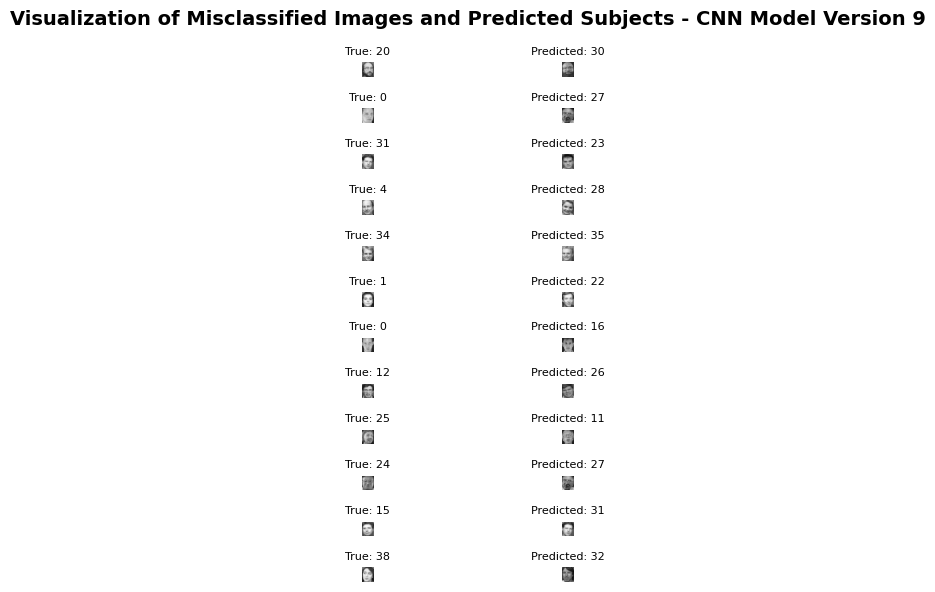

In [65]:
# Calculate misclassified indices for CNN Model Version 9
misclassified_cnn_v9 = np.where(np.argmax(y_pred_v4, axis=1) != np.argmax(y_test_encoded, axis=1))[0]

# Set the number of rows and columns for the subplots
rows_cnn_v9 = len(misclassified_cnn_v9)
cols = 2

# Check if rows_cnn_v9 is zero
if rows_cnn_v9 == 0:
    print("No misclassified images for CNN Model Version 9.")
else:
    # Create the subplot grid
    fig, axes = plt.subplots(rows_cnn_v9, cols, figsize=(6, 6))

    # Iterate through CNN Model Version 9 misclassified images and display the corresponding images
    for i, index in enumerate(misclassified_cnn_v9):
        img = X_test_original[index]
        true_label = np.argmax(y_test_encoded[index])
        pred_label = np.argmax(y_pred_v4[index])

        # Find the indices of images for the predicted subject
        predicted_subject_indices = np.where(np.argmax(y_test_encoded, axis=1) == pred_label)[0]

        # Check if there are any images available for the predicted subject
        if len(predicted_subject_indices) > 0:
            # Retrieve the first image of the predicted subject
            predicted_subject_index = predicted_subject_indices[0]
            predicted_subject_image = X_test_original[predicted_subject_index]

            # Plot the true subject image
            axes[i, 0].imshow(img, cmap=plt.cm.gray)
            axes[i, 0].set_title(f"True: {true_label}", fontsize=8)
            axes[i, 0].axis('off')

            # Plot the predicted subject image
            axes[i, 1].imshow(predicted_subject_image, cmap=plt.cm.gray)
            axes[i, 1].set_title(f"Predicted: {pred_label}", fontsize=8)
            axes[i, 1].axis('off')

    # Remove any empty subplots if the number of misclassified images is not a multiple of the number of columns
    if rows_cnn_v9 % cols != 0:
        for i in range(rows_cnn_v9 % cols + 1, cols):
            fig.delaxes(axes[-1, i])

    plt.suptitle("Visualization of Misclassified Images and Predicted Subjects - CNN Model Version 9", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# PySpark 

In [66]:
# Initialize a dictionary to hold average pixel intensities for each of the 40 individuals (class)
average_pixel_intensities = {}

# Iterate over each class
for class_name in set(y_data):
    # Find all images belonging to this class
    class_images = [image for image, label in zip(X_data, y_data) if label == class_name]
    
    # Calculate average pixel intensity for this class
    average_pixel_intensity = np.mean([np.mean(image) for image in class_images])
    
    # Store the result in our dictionary
    average_pixel_intensities[class_name] = average_pixel_intensity

# Print the results
for class_name, avg_intensity in average_pixel_intensities.items():
    print(f"Average pixel intensity for {class_name}: {avg_intensity}")

Average pixel intensity for s27: 113.87108889751553
Average pixel intensity for s37: 109.10439635093167
Average pixel intensity for s32: 125.42356366459629
Average pixel intensity for s19: 120.02870729813665
Average pixel intensity for s3: 115.87922166149069
Average pixel intensity for s26: 121.01328610248447
Average pixel intensity for s18: 135.52746506211182
Average pixel intensity for s9: 113.32507763975157
Average pixel intensity for s11: 102.36776979813665
Average pixel intensity for s2: 112.65321234472049
Average pixel intensity for s38: 108.30481366459628
Average pixel intensity for s1: 136.70140722049686
Average pixel intensity for s25: 124.24754464285714
Average pixel intensity for s16: 121.01252911490683
Average pixel intensity for s15: 112.20925854037269
Average pixel intensity for s17: 113.92699922360248
Average pixel intensity for s34: 97.42004076086957
Average pixel intensity for s20: 101.92547554347827
Average pixel intensity for s36: 111.48193905279501
Average pixel int

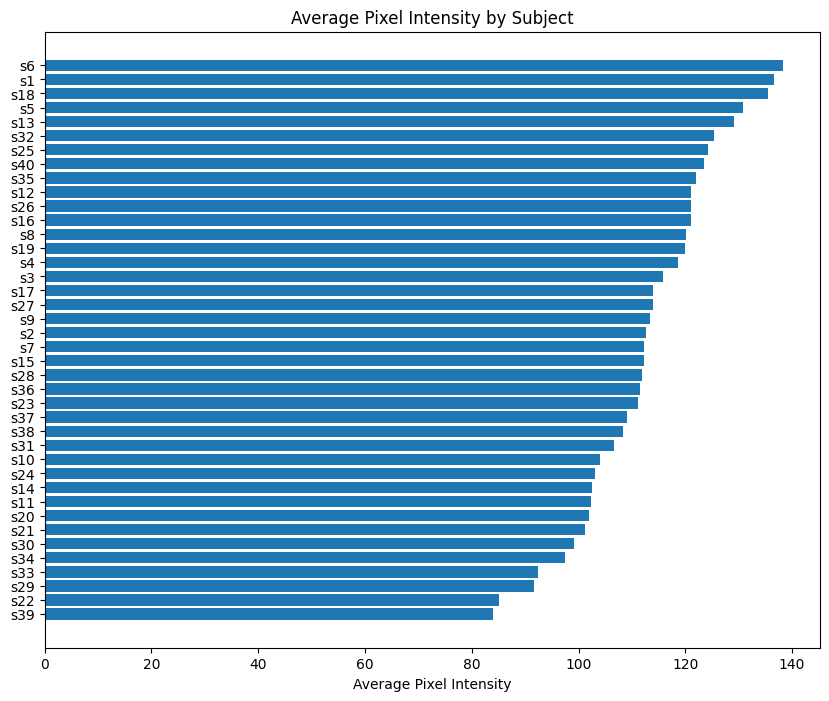

In [67]:
# Create DataFrame from dictionary
average_pixel_intensities_df = pd.DataFrame(list(average_pixel_intensities.items()), columns=['Subject', 'Average Pixel Intensity'])

# Sort DataFrame by 'Average Pixel Intensity'
average_pixel_intensities_df = average_pixel_intensities_df.sort_values('Average Pixel Intensity')

# Plot bar chart
plt.figure(figsize=(10,8))
plt.barh(average_pixel_intensities_df['Subject'], average_pixel_intensities_df['Average Pixel Intensity'])
plt.xlabel('Average Pixel Intensity')
plt.title('Average Pixel Intensity by Subject')
plt.show()

In [68]:
# Convert average_pixel_intensities dictionary to a list of tuples
data = [(str(subject), float(avg_intensity)) for subject, avg_intensity in average_pixel_intensities.items()]

# Create Spark session
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

# Create DataFrame from the list of tuples
avg_pixel_df = spark.createDataFrame(data, ["Subject", "Average Pixel Intensity"])

# Sort the DataFrame by 'Average Pixel Intensity'
avg_pixel_df = avg_pixel_df.orderBy('Average Pixel Intensity')

# Show the DataFrame
avg_pixel_df.show()

+-------+-----------------------+
|Subject|Average Pixel Intensity|
+-------+-----------------------+
|    s39|      83.92661102484473|
|    s22|       85.1676921583851|
|    s29|      91.63590838509317|
|    s33|      92.42089479813666|
|    s34|      97.42004076086957|
|    s30|      99.23293866459628|
|    s21|     101.22831909937887|
|    s20|     101.92547554347827|
|    s11|     102.36776979813665|
|    s14|     102.43626746894411|
|    s24|     103.14790372670807|
|    s10|     104.09259510869565|
|    s31|     106.60304736024844|
|    s38|     108.30481366459628|
|    s37|     109.10439635093167|
|    s23|     111.16773097826088|
|    s36|     111.48193905279501|
|    s28|     111.90132958074534|
|    s15|     112.20925854037269|
|     s7|     112.24663237577639|
+-------+-----------------------+
only showing top 20 rows

